# Analysis and Visualisation 

## Load preprocessed data

In [35]:
#!pip install datasets
#!pip install gensim

In [2]:
import datasets
from datasets import load_dataset, load_from_disk

tldr_cleaned_sample = load_from_disk('tldr_cleaned_sample_dict')


c:\Users\Estelle\miniconda3\envs\docana\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from wordcloud import WordCloud
from matplotlib import cm
from matplotlib.colors import Normalize

## First overview

In [4]:
tldr_cleaned_sample

Dataset({
    features: ['author', 'body', 'normalizedBody', 'subreddit', 'subreddit_id', 'id', 'content', 'summary', 'clean', 'avg_vec', 'evidence_sim', 'intuition_sim', 'length_bin', 'z_evidence', 'z_intuition', 'emi', 'clean_short', 'avg_vec_short', 'evidence_sim_short', 'intuition_sim_short', 'length_bin_short', 'z_evidence_short', 'z_intuition_short', 'emi_short', 'avg_vec_dict', 'evidence_sim_dict', 'intuition_sim_dict', 'length_bin_dict', 'z_evidence_dict', 'z_intuition_dict', 'emi_dict'],
    num_rows: 615392
})

### Predefine colors <3

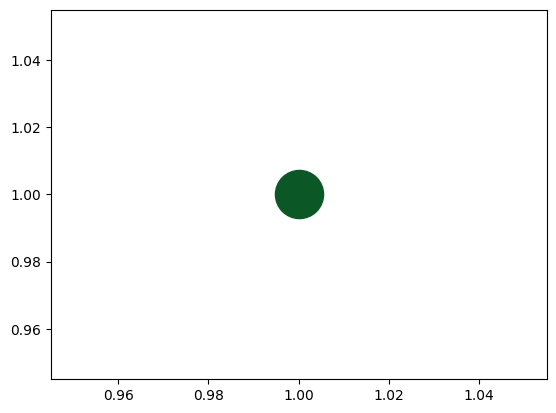

In [4]:
colormap = plt.get_cmap('PRGn')  
plt.scatter(x = [0], y = [0], s =1200, color= colormap(30), label = 'intuition')
plt.scatter(x = [1], y = [1], s =1200, color= colormap(245), label = 'evidence')
intColor = colormap(30)
evColor = colormap(245)
baseColor = colormap(45) ##7194e3

In [7]:
import matplotlib.colors as mcolors

# Normalize index (e.g., 30 out of 255 steps)
rgba = colormap(30 / 255)
hex_color = mcolors.to_hex(rgba)

print(hex_color)

#7c368a


## Start with comparison of EMI scores of subreddits

### Show subreddits EMI score

In [6]:
# to pandas for easier visualisation 
import math
tldr_df = tldr_cleaned_sample.to_pandas()
# histograms 
subreddits = tldr_df['subreddit'].unique()
num_subreddits = len(subreddits)

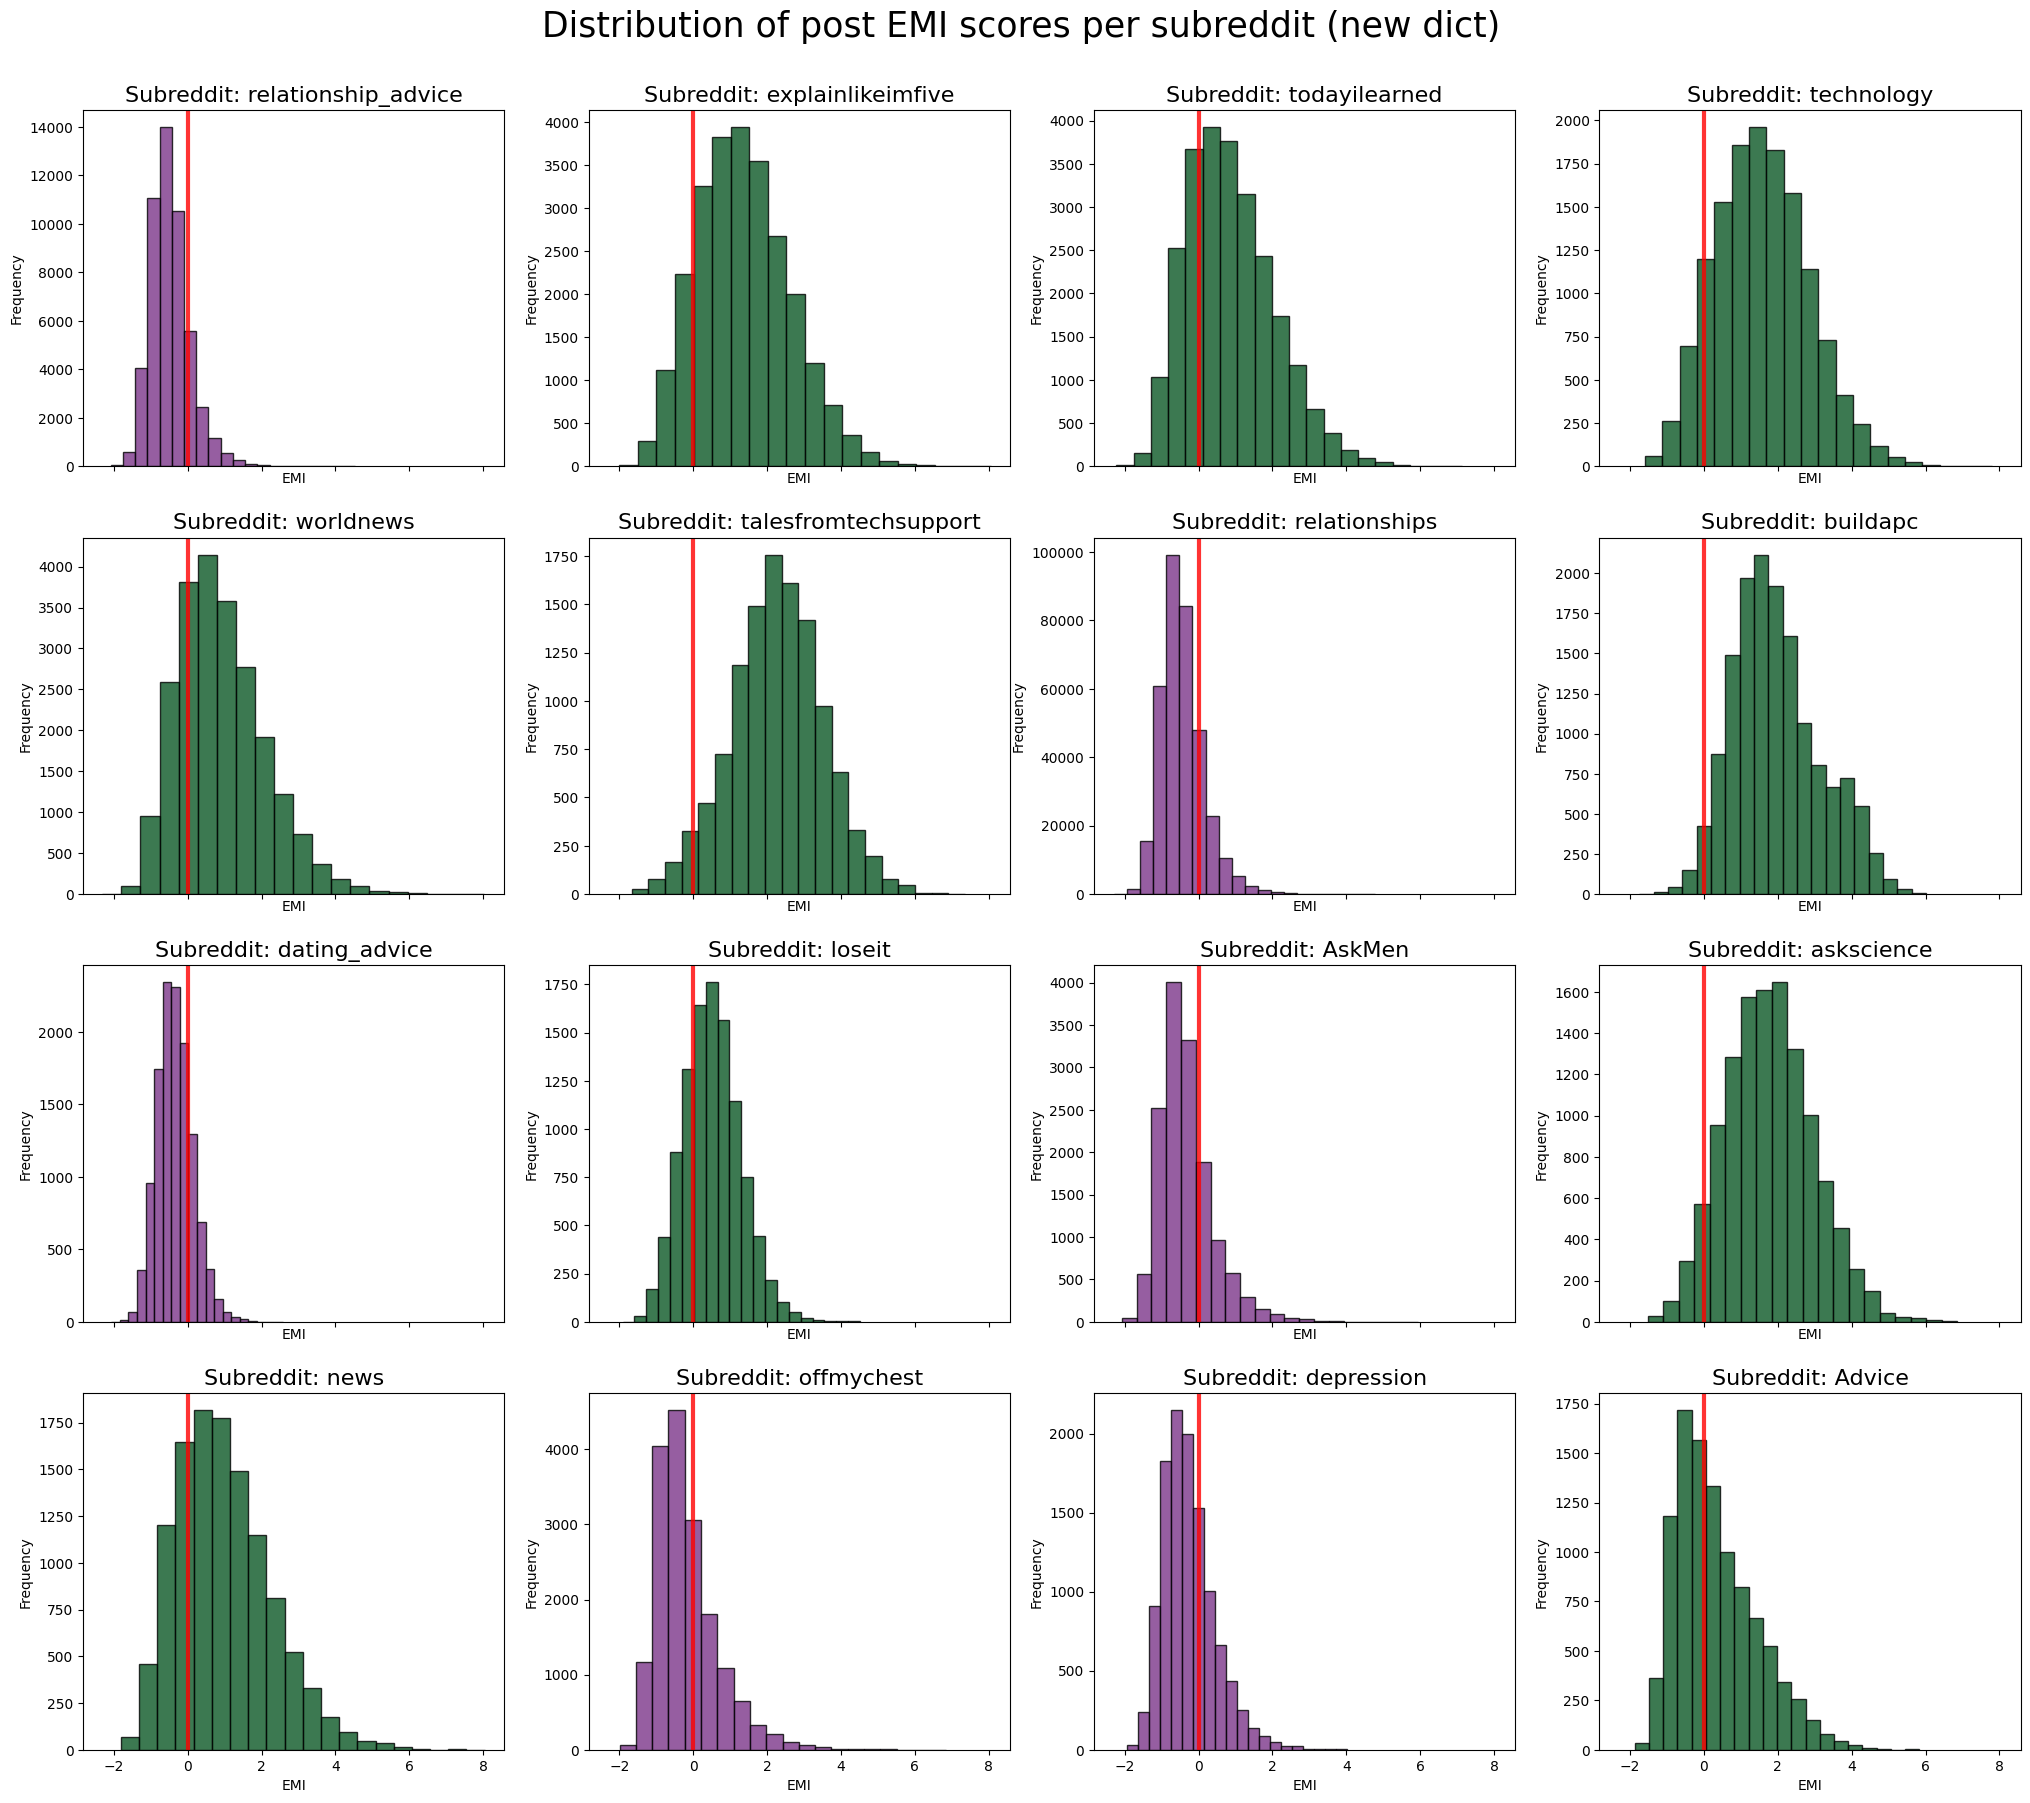

In [54]:
#plt.figure(figsize=(5 * num_subreddits, 15))
fig, axs = plt.subplots(math.ceil(num_subreddits/4),4, figsize=(25, 20), sharex = True)
axs = axs.flatten()
for i, subreddit in enumerate(subreddits):
    #plt.subplot(2, round(num_subreddits/2), i + 1)
    subset = tldr_df[tldr_df['subreddit'] == subreddit]
    mean_emi = subset['emi_dict'].mean()
    color = evColor if mean_emi > 0 else intColor
    axs[i].hist(subset['emi_dict'], bins=20, color= color, edgecolor='black', alpha = 0.8)
    axs[i].set_title(f"Subreddit: {subreddit}", size = 16)
    axs[i].set_xlabel('EMI')
    axs[i].set_ylabel('Frequency')
    axs[i].axvline(0, color = 'red', linewidth = 3, alpha = 0.8 )
fig.suptitle('Distribution of post EMI scores per subreddit (new dict)', fontsize = 25)
fig.subplots_adjust(top=0.93)
plt.show()

-9.057516058962413e-17
1.1047190777733071


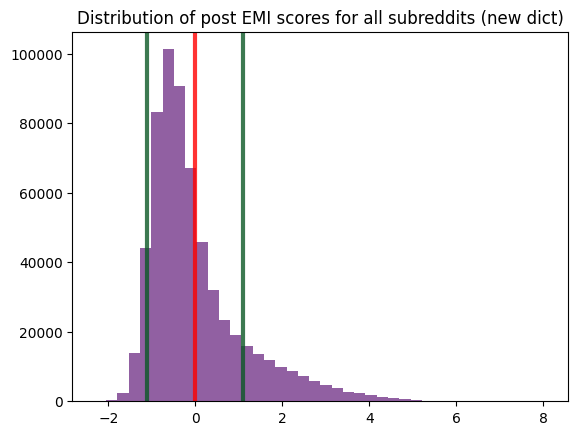

In [55]:
print(tldr_df['emi_dict'].mean())
print(tldr_df['emi_dict'].std())
plt.title('Distribution of post EMI scores for all subreddits (new dict)')
plt.hist(tldr_df['emi_dict'], bins=40, color=baseColor)
plt.axvline(tldr_df['emi_dict'].mean(), color = 'red', linewidth = 3, alpha = 0.8)
plt.axvline(tldr_df['emi_dict'].mean()+tldr_df['emi_dict'].std(), color = evColor, linewidth = 3, alpha = 0.8)
plt.axvline(tldr_df['emi_dict'].mean()-tldr_df['emi_dict'].std(), color = evColor, linewidth = 3, alpha = 0.8)
plt.show()

## Top x token wordcloud

### Adding word EMI for wordcloud

In [3]:
import pickle
# new created evidence and inutition sets 
with open("../preprocessing_EMI/evidence_set_final.pkl", "rb") as f:
    evidence_set = pickle.load(f)

with open("../preprocessing_EMI/intuition_set_final.pkl", "rb") as g:
    intuition_set = pickle.load(g)

In [8]:
# cosine similarity for map
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_a = np.linalg.norm(vec1)
    norm_b = np.linalg.norm(vec2)
    
    if norm_a == 0 or norm_b == 0:
        return 0.0  # Avoid division by zero
    
    return dot_product / (norm_a * norm_b)

In [9]:
# average the vectors per post to calculate similarity to evidence and intuition vectors
def get_avg_vectors(tokens, model):
    
    # Filter tokens that are in the model's vocabulary
    valid_tokens = [token for token in tokens if token in model.wv]
    
    if not valid_tokens:
        return [], [np.zeros(model.vector_size)* len(tokens)] ,np.zeros(model.vector_size)  # Return a zero vector if no valid tokens
    
    # Get vectors for the valid tokens
    word_vectors = np.array([model.wv[token] for token in valid_tokens])
    
    # Compute the average of word vectors
    avg_vector = np.mean(word_vectors, axis=0)
    return valid_tokens, word_vectors, avg_vector

In [10]:
def get_emi_token(word, model, e_vec, i_vec):
    
    # Filter tokens that are in the model's vocabulary
    if not word in model.wv:
        return 0
    
    
    # Get the word vectors for the valid tokens
    word_vec = model.wv[word]
    evidence_sim = np.float32(cosine_similarity(word_vec, e_vec))
    intuition_sim = np.float32(cosine_similarity(word_vec, i_vec))

    emi = evidence_sim - intuition_sim
    
    return emi 

In [11]:
# get evidence and intuition vector 
from gensim.models import Word2Vec
model = Word2Vec.load("word2vec_tldr_dict.model")

valid_evidence, evidence_vectors, evidence_vector = get_avg_vectors(evidence_set, model)
valid_intuition, inuition_vectors, intuition_vector = get_avg_vectors(intuition_set, model)

In [12]:
# get token counting dict and then EMI score for those tokens, but EMI usually averaged so no z standardization with binning for now 
word_stats = {}
word_stats_df = {}

for reddit in subreddits: 

    words = [word for sublist in tldr_df[tldr_df['subreddit'] == reddit]['clean'] for word in sublist]
    word_stats[reddit] = {}
    for word in words:
        if word not in word_stats[reddit]:
            word_stats[reddit][word] = {
                'count': 1,
                'emi_dict': get_emi_token(word, model, evidence_vector, intuition_vector)
            }
        else:
            word_stats[reddit][word]['count'] += 1

    
    word_stats_df[reddit] = pd.DataFrame.from_dict(word_stats[reddit], orient='index').rename_axis('word').reset_index().sort_values('count', ascending=False)



In [ ]:
# get max and min EMI scored words
for reddit in subreddits: 

    df = word_stats_df[reddit]

    # 2. Create word-to-emi and word-to-frequency mappings
    word_values = dict(zip(df['word'], df['emi_dict']))
    frequencies = dict(zip(df['word'], df['count']))

word_emi_dict = pd.DataFrame(
    sorted(word_values.items(), key=lambda item: item[1]),
    columns=["word", "value"]
)

print(word_emi_dict.head(10))
print(word_emi_dict.tail(10))

posx and posy should be finite values


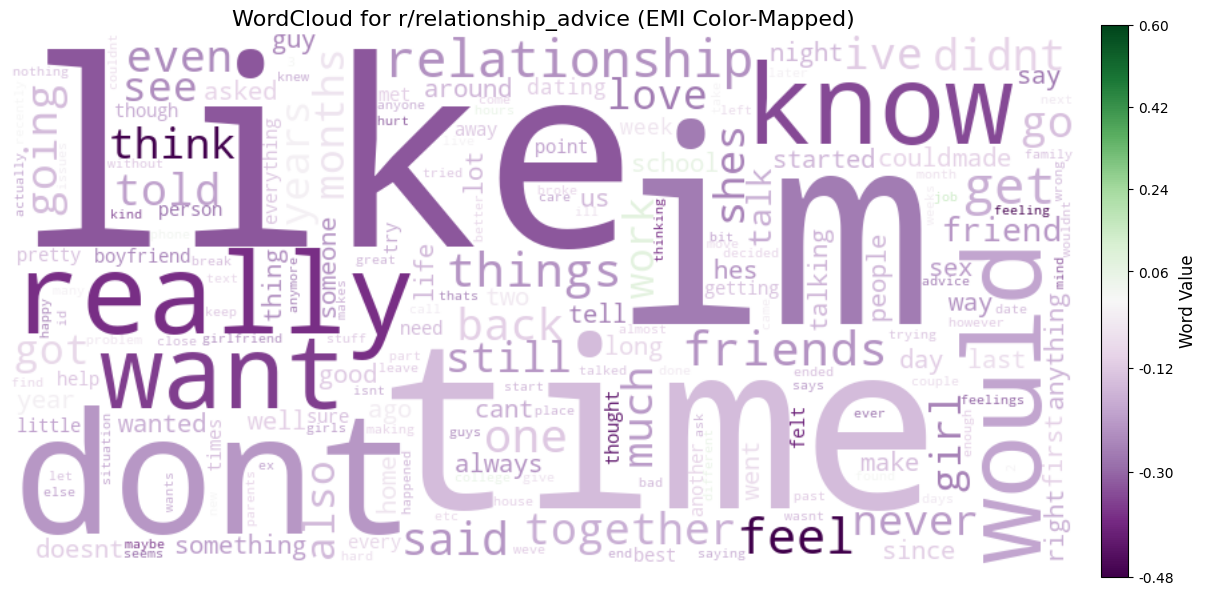

posx and posy should be finite values


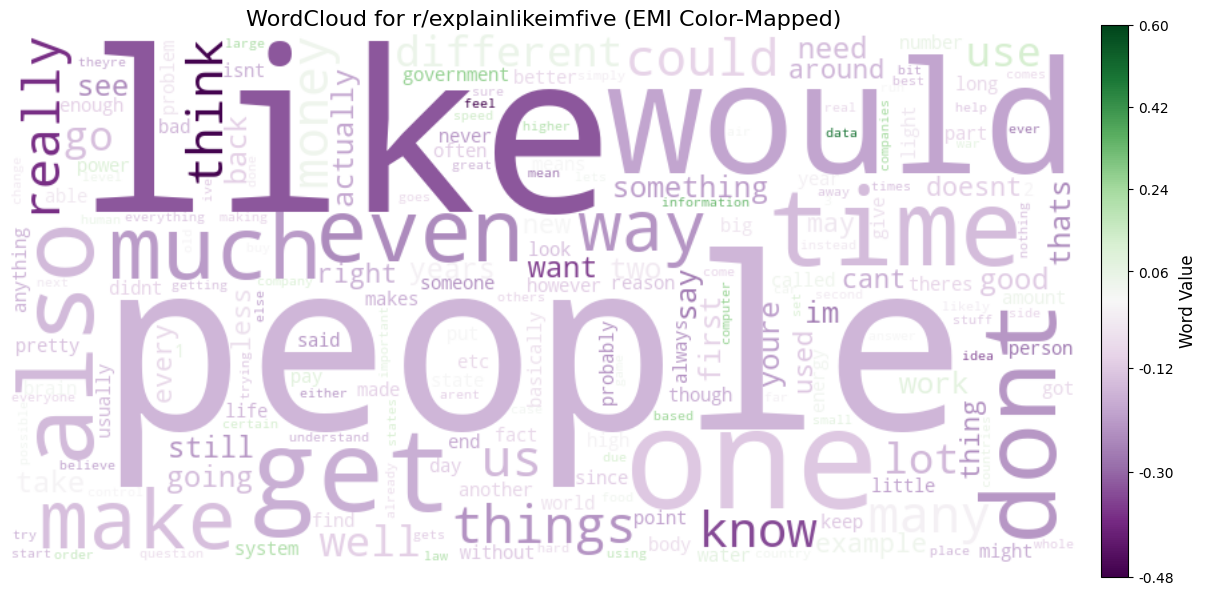

posx and posy should be finite values


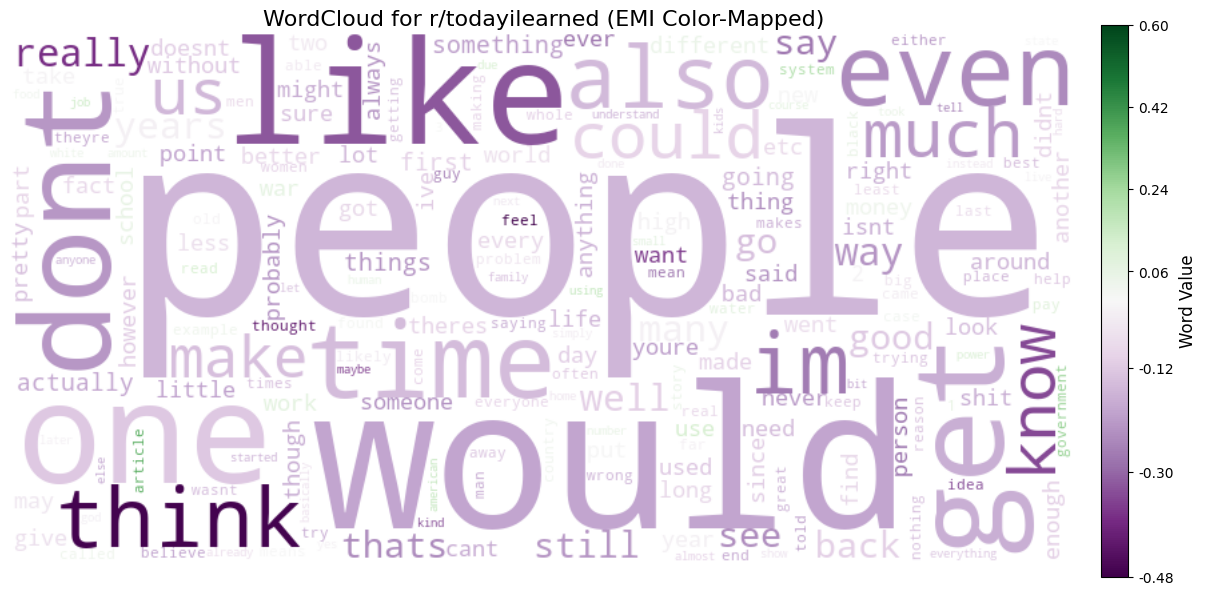

posx and posy should be finite values


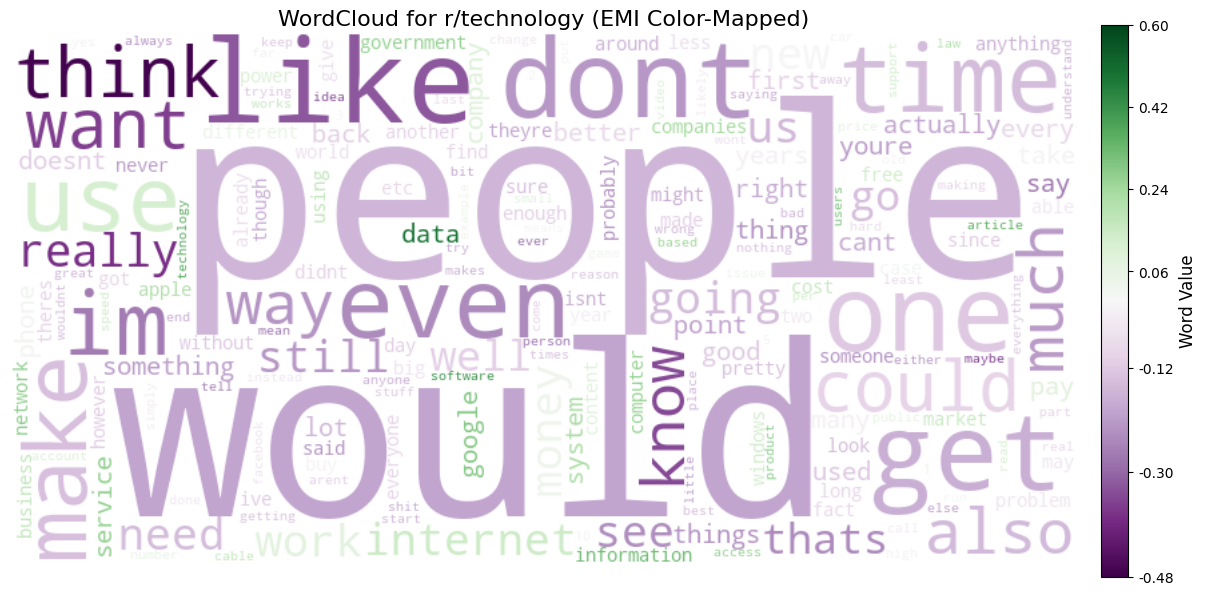

posx and posy should be finite values


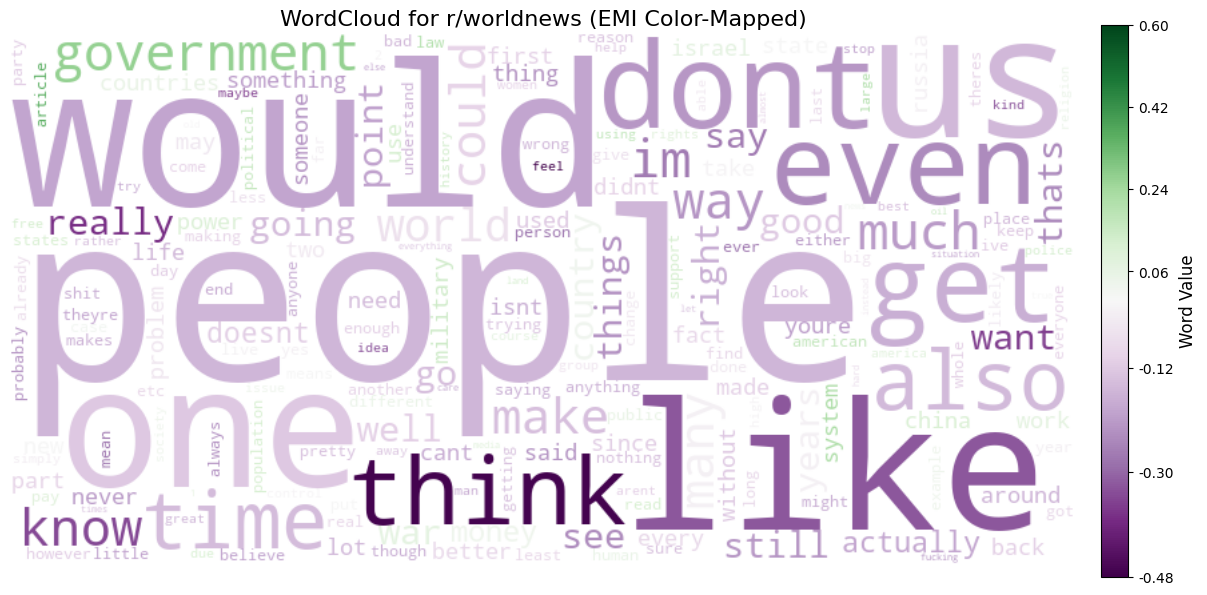

posx and posy should be finite values


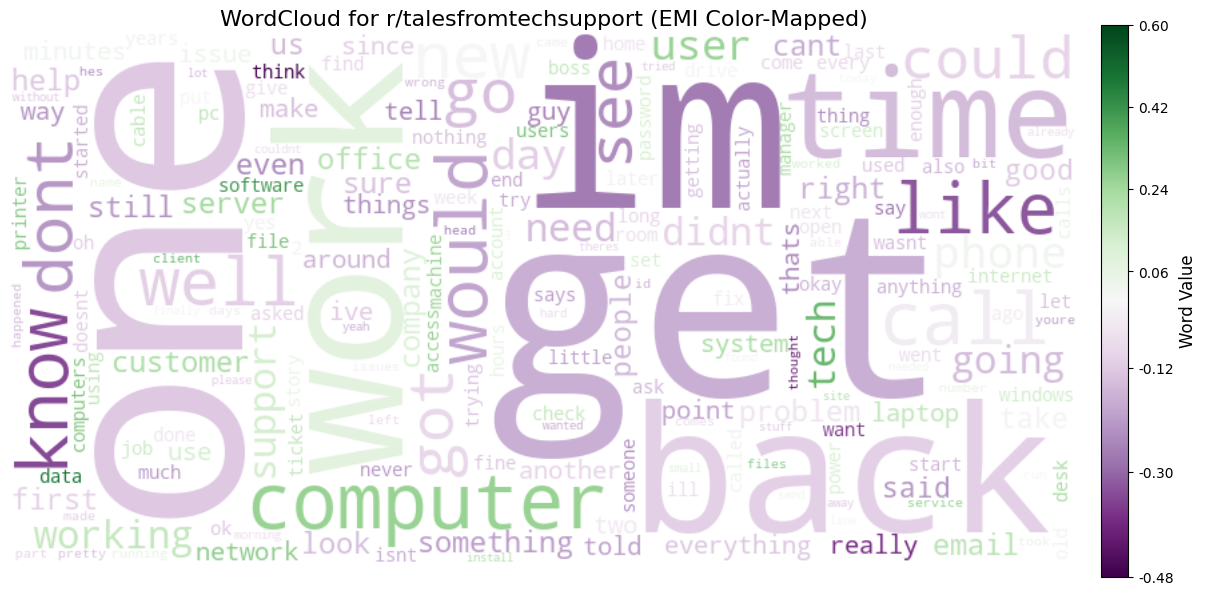

posx and posy should be finite values


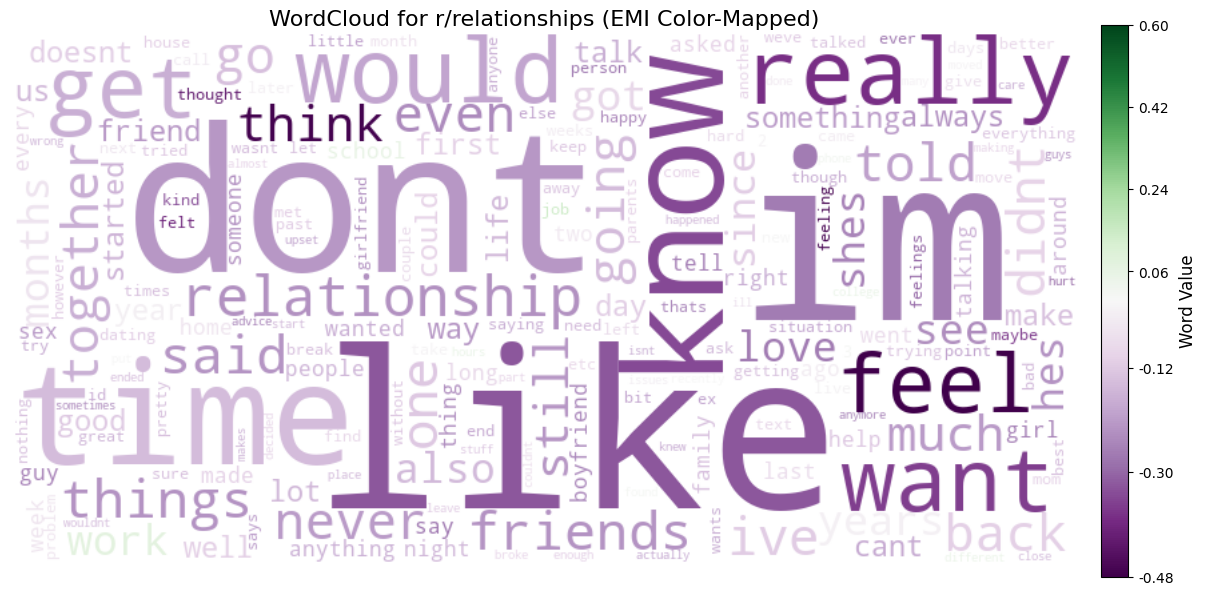

posx and posy should be finite values


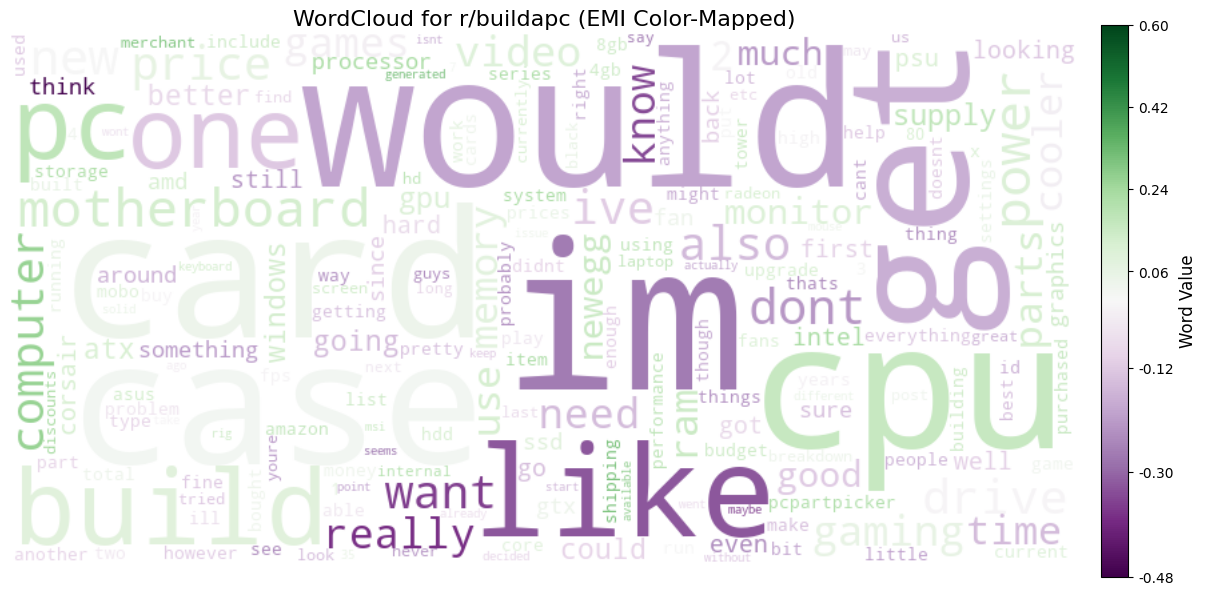

posx and posy should be finite values


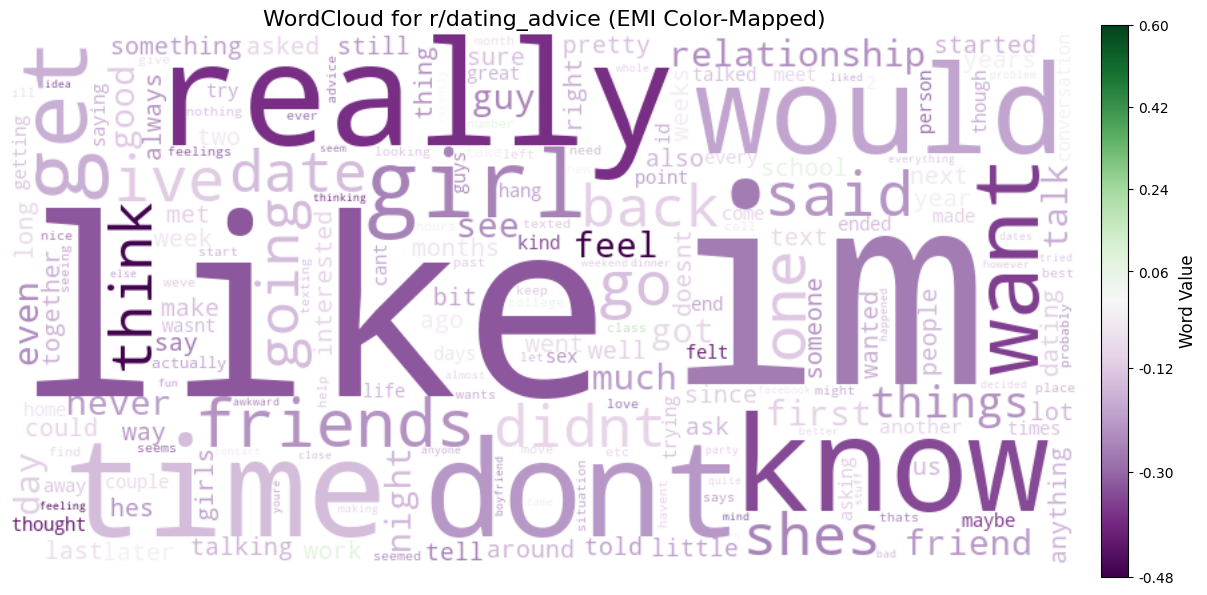

posx and posy should be finite values


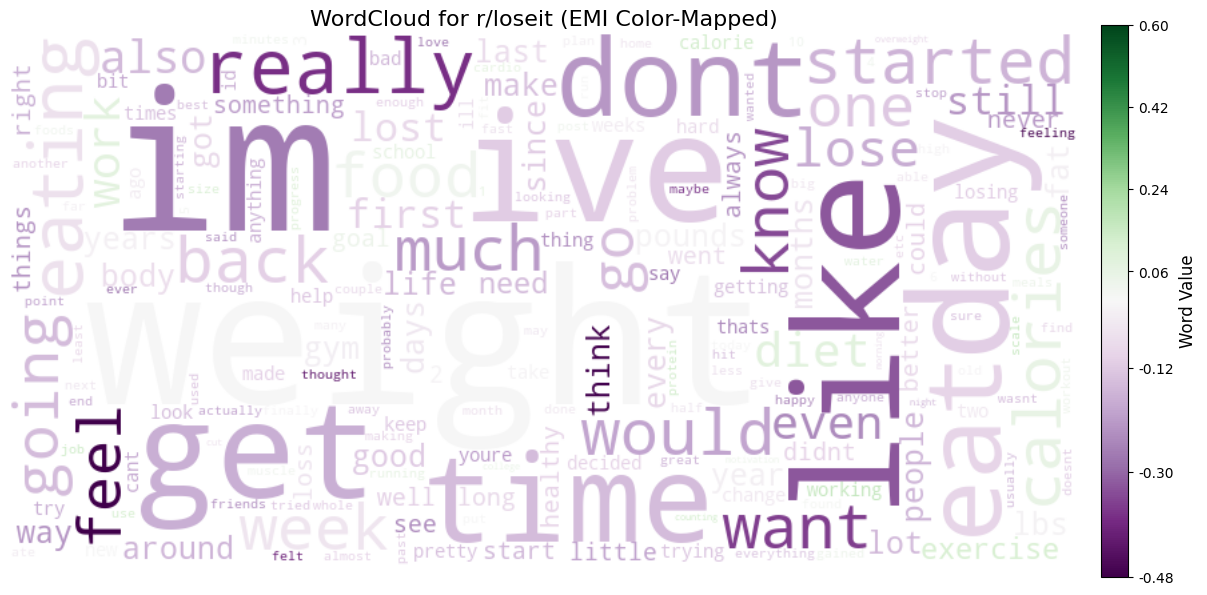

posx and posy should be finite values


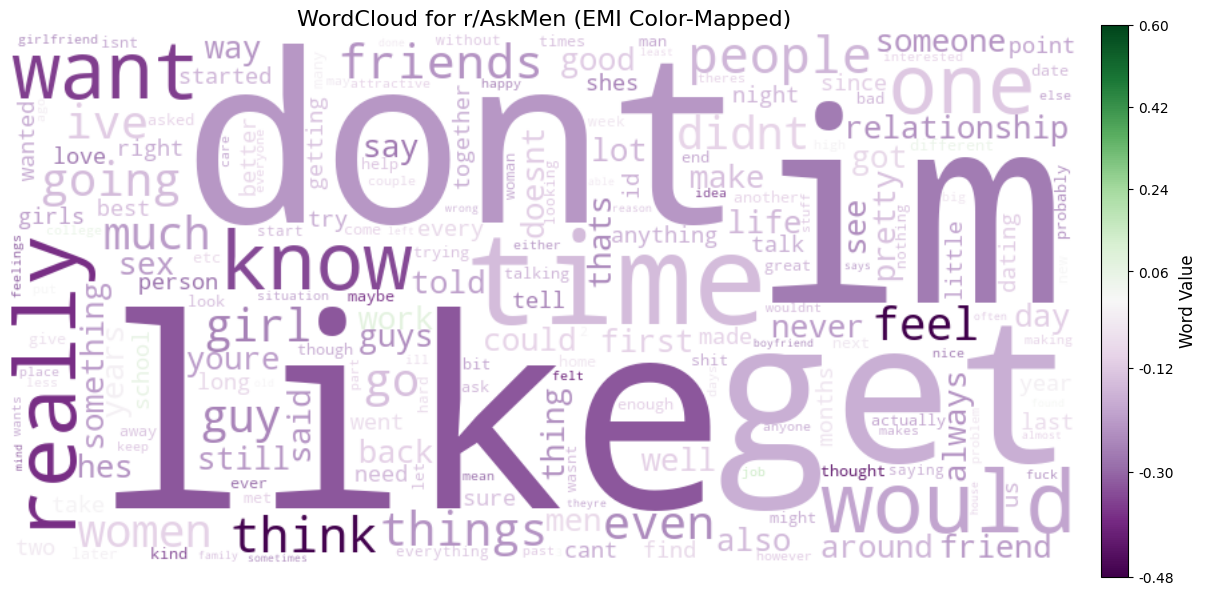

posx and posy should be finite values


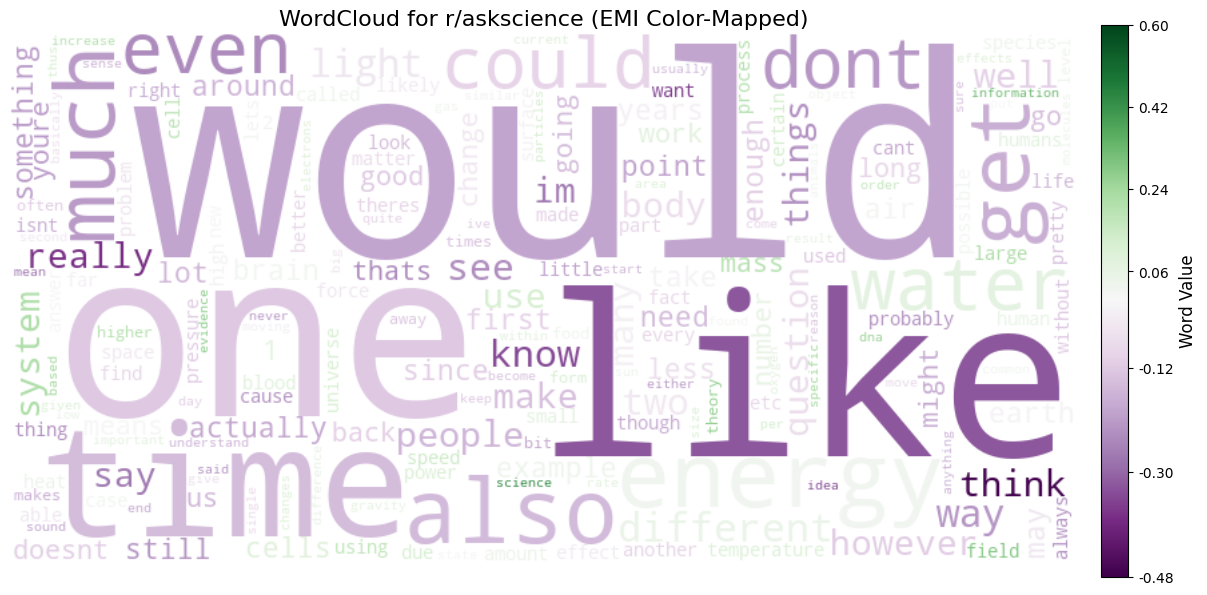

posx and posy should be finite values


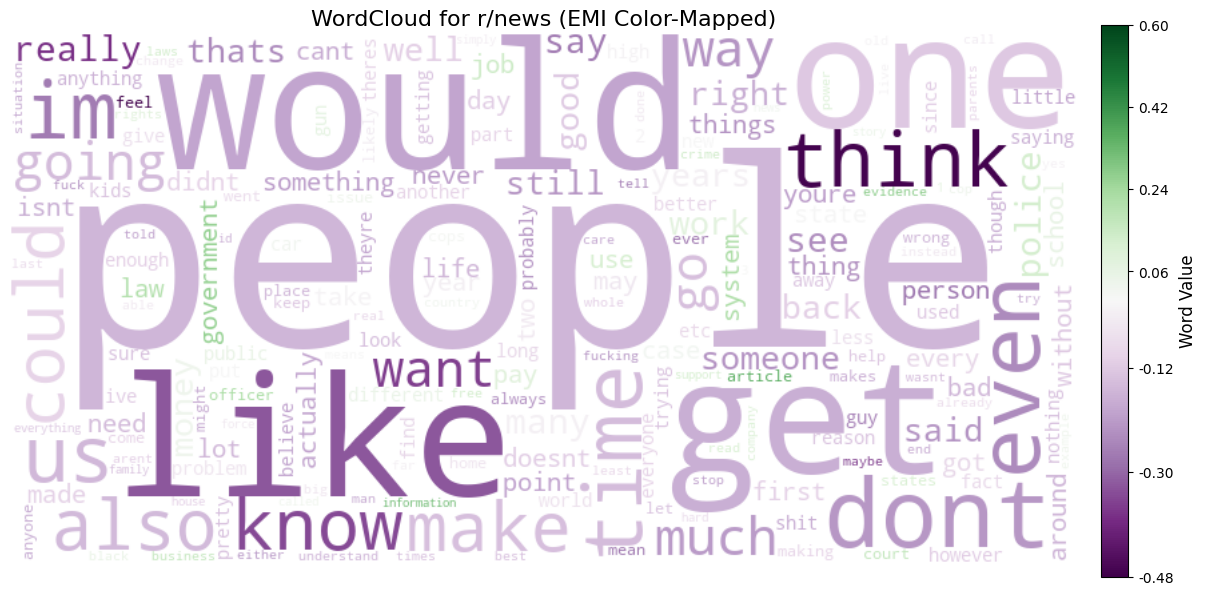

posx and posy should be finite values


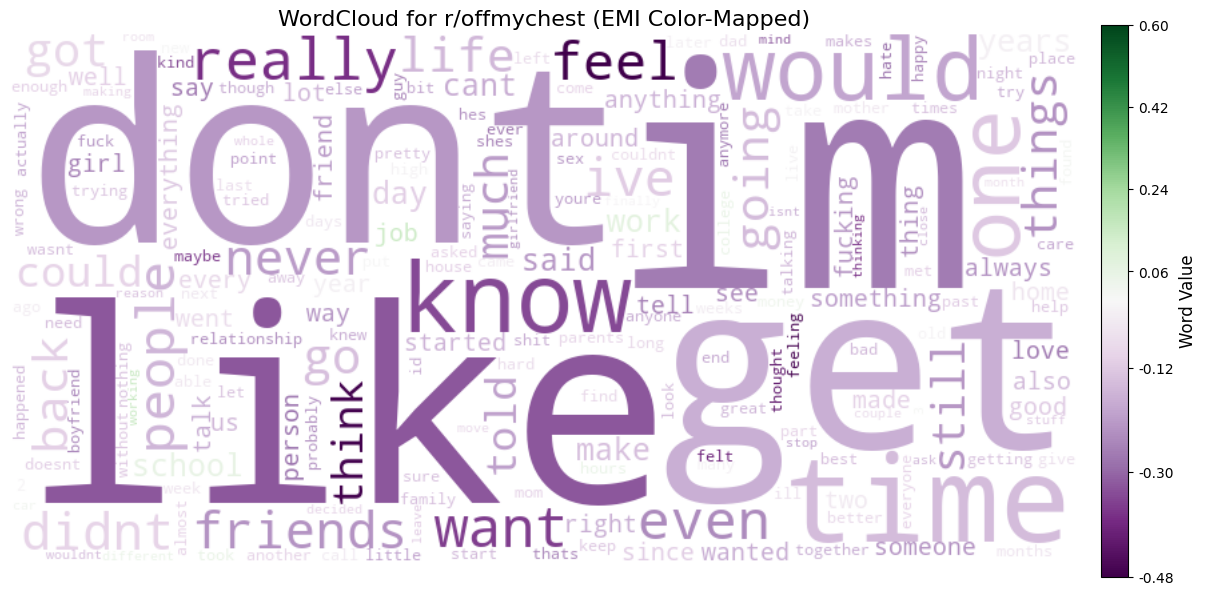

posx and posy should be finite values


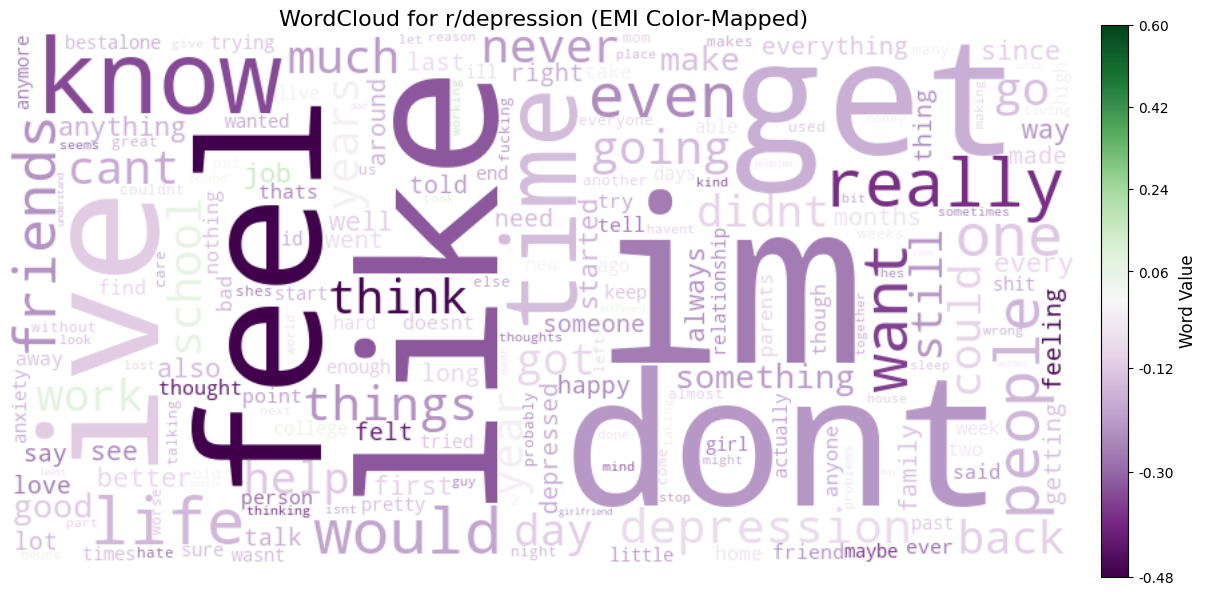

posx and posy should be finite values


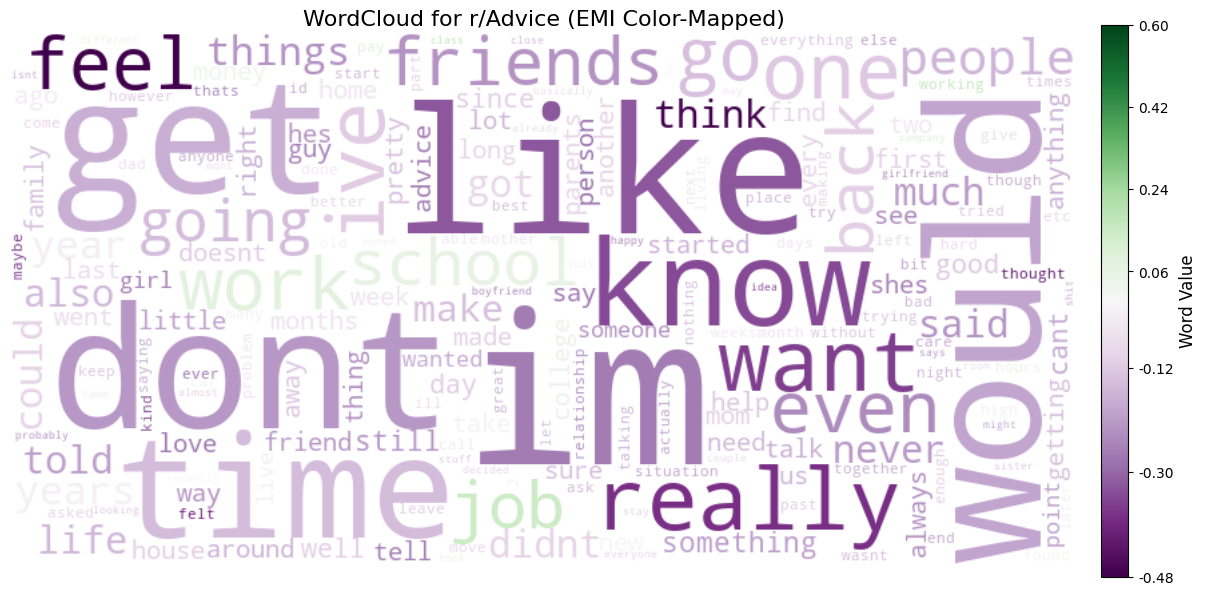

In [62]:
from matplotlib import cm
from matplotlib.colors import Normalize, TwoSlopeNorm

for reddit in subreddits: 

    df = word_stats_df[reddit]

    # 2. Create word-to-emi and word-to-frequency mappings
    word_values = dict(zip(df['word'], df['emi_dict']))
    frequencies = dict(zip(df['word'], df['count']))

    # 3. Normalize EMI values for color mapping
    vmin = min(word_values.values())
    vmax = max(word_values.values())
    vcenter = 0

    # Use TwoSlopeNorm to keep 0 as the center
    norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

    def colormap_func(word, font_size, position, orientation, font_path, random_state):
        value = word_values.get(word, 0)
        rgba = colormap(norm(value))  
        r, g, b, _ = [int(255 * x) for x in rgba]
        return f"rgb({r}, {g}, {b})"

    # 5. Generate and color the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frequencies)
    wordcloud = wordcloud.recolor(color_func=colormap_func)

    # 6. Plot it
    fig, ax = plt.subplots(figsize=(12, 6))
    img = ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"WordCloud for r/{reddit} (EMI Color-Mapped)", fontsize=16)

    # Create ScalarMappable to use with colorbar
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])  # required dummy array

    ticks = np.linspace(vmin, vmax, num=7)  # More ticks
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.05, pad=0.02)
    cbar.set_label("Word Value", fontsize=12)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{t:.2f}" for t in ticks])


    plt.tight_layout()
    plt.show()


## Barplots of EMI score

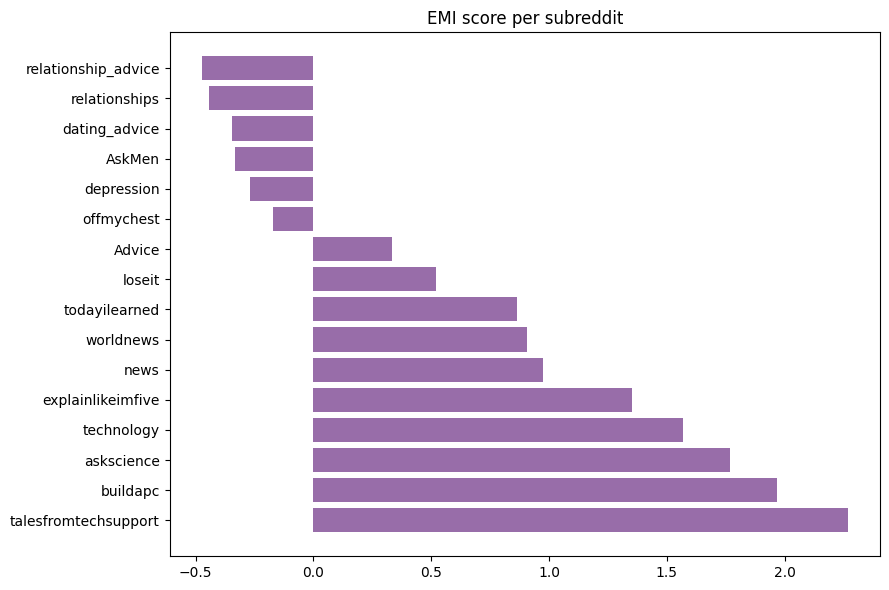

In [63]:
mean_subreddit_emi_df = pd.DataFrame(tldr_df.groupby('subreddit')['emi_dict'].mean().reset_index().rename(columns={'emi_dict': 'mean_emi_dict'})).sort_values('mean_emi_dict')

plt.figure(figsize=(9, 6))
plt.barh(mean_subreddit_emi_df['subreddit'], mean_subreddit_emi_df['mean_emi_dict'], color=colormap(50))
plt.gca().invert_yaxis()  
plt.title("EMI score per subreddit")
plt.tight_layout()
plt.show()


## Subreddit vector representation

In [64]:
subreddit_avg_vec_df = tldr_df.groupby('subreddit')['avg_vec_dict'].apply(lambda vectors: np.mean(np.stack(vectors), axis=0)).reset_index()

In [65]:
from sklearn.decomposition import PCA


vecs_pca = np.stack(list(subreddit_avg_vec_df['avg_vec_dict'].values)+ [evidence_vector, intuition_vector])

pca = PCA(n_components=2) 
avg_vec_2d = pca.fit_transform(vecs_pca)

subreddit_avg_vec_df[['pc1', 'pc2']] = avg_vec_2d[:-2]

In [76]:
# add mean emi for coloring 
mean_emi_per_subreddit = tldr_df.groupby('subreddit')['emi_dict'].mean()

# Join the mean EMI to the main dataframe on subreddit
subreddit_avg_vec_df = subreddit_avg_vec_df.join(mean_emi_per_subreddit, on='subreddit')
subreddit_avg_vec_df = subreddit_avg_vec_df.rename(columns={'emi_dict': 'mean_emi_dict'})

In [77]:
subreddit_avg_vec_df

subreddit                                       avg_vec_dict  \
0                 Advice  [-0.11711008, -0.5533028, 0.3721167, 0.0516475...   
1                 AskMen  [-0.19374701, -0.5041719, 0.39156225, 0.102739...   
2             askscience  [-0.036189582, 0.010258127, 0.20005491, 0.2046...   
3               buildapc  [0.16073877, 0.12978563, 0.09689648, 0.0941953...   
4          dating_advice  [-0.18799908, -0.6139353, 0.32091522, 0.087827...   
5             depression  [-0.114501, -0.6041582, 0.387594, 0.05728397, ...   
6      explainlikeimfive  [-0.035938926, -0.16938683, 0.19081964, 0.1092...   
7                 loseit  [-0.08537293, -0.521711, 0.26039916, 0.1373432...   
8                   news  [-0.08031532, -0.3139977, 0.159487, 0.07235781...   
9             offmychest  [-0.16015288, -0.6072259, 0.39342523, 0.075565...   
10   relationship_advice  [-0.19716045, -0.67100364, 0.35955444, 0.03955...   
11         relationships  [-0.19392338, -0.67728084, 0.35204443, 0.02579...   
12  talesfromtechsupport  [0.13159513, -0.30699846, 0.1796801, 0.1261209...   
13            technology  [0.03665879, -0.1641977, 0.17896079, 0.0563943...   
14         todayilearned  [-0.09885264, -0.24897087, 0.17428416, 0.07099...   
15             worldnews  [-0.06410937, -0.30731383, 0.089688525, 0.0311...   

         pc1       pc2  mean_emi  mean_emi_dict  
0   1.674433 -0.260930  0.333999       0.333999  
1   1.651530  0.322857 -0.333857      -0.333857  
2  -1.828649 -0.996876  1.769951       1.769951  
3  -1.663111 -1.721684  1.965890       1.965890  
4   2.905172  0.383066 -0.346307      -0.346307  
5   1.953055  0.377372 -0.268941      -0.268941  
6  -1.211152 -1.004917  1.354175       1.354175  
7   0.716163 -0.826764  0.520622       0.520622  
8  -0.818018 -0.751252  0.974475       0.974475  
9   1.933625  0.091440 -0.173061      -0.173061  
10  2.782775  0.521244 -0.473538      -0.473538  
11  2.735593  0.442586 -0.442456      -0.442456  
12 -0.857655 -1.496828  2.267735       2.267735  
13 -1.324436 -1.132247  1.568976       1.568976  
14 -0.754829 -0.802433  0.863641       0.863641  
15 -1.048596 -0.688718  0.904538       0.904538

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


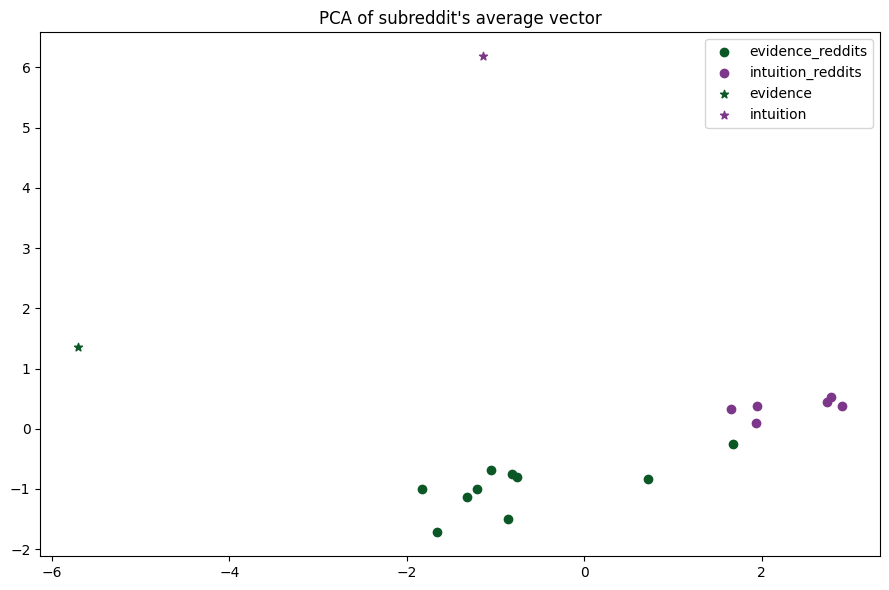

In [78]:
evidence_pca = subreddit_avg_vec_df[subreddit_avg_vec_df['mean_emi_dict'] >= 0]
intuition_pca = subreddit_avg_vec_df[subreddit_avg_vec_df['mean_emi_dict'] < 0]
plt.figure(figsize=(9, 6))
plt.scatter(evidence_pca['pc1'], evidence_pca['pc2'], c=evColor, label='evidence_reddits')
plt.scatter(intuition_pca['pc1'], intuition_pca['pc2'], c=intColor, label='intuition_reddits')
plt.scatter(avg_vec_2d[-2:-1][0][0], avg_vec_2d[-2:-1][0][1], color = evColor, label = 'evidence', marker='*')
plt.scatter(avg_vec_2d[-1:][0][0], avg_vec_2d[-1:][0][1], color = intColor, label = 'intuition', marker='*')
plt.title("PCA of subreddit's average vector")
plt.legend()
plt.tight_layout()
plt.show()

## PCA on posts

In [79]:
tldr_df_pca = tldr_df[['subreddit', 'emi_dict', 'avg_vec_dict']]

vecs_pca_tot = np.stack(list(tldr_df_pca['avg_vec_dict'].values)+ [evidence_vector, intuition_vector])

pca = PCA(n_components=2) 
avg_vec_2d_tot = pca.fit_transform(vecs_pca_tot)

tldr_df_pca.loc[:, ['pc1', 'pc2']] = avg_vec_2d_tot[:-2]

In [80]:
tldr_df_pca

subreddit  emi_dict  \
0       relationship_advice -0.767610   
1       relationship_advice -0.189950   
2         explainlikeimfive  1.471383   
3             todayilearned  0.815440   
4                technology  2.386817   
...                     ...       ...   
615387               loseit  0.460198   
615388  relationship_advice -0.679367   
615389           offmychest  0.103420   
615390        relationships -0.614980   
615391        relationships -0.743231   

                                             avg_vec_dict       pc1       pc2  
0       [-0.10280032, -0.40822038, 0.43277648, 0.09343... -0.600368  2.283996  
1       [-0.21330304, -0.5165435, 0.2394814, 0.0031160...  0.165450  1.528079  
2       [-0.07379622, -0.21365789, 0.22330719, -0.0058...  2.700031  0.318189  
3       [-0.112017885, -0.19993548, 0.6765367, 0.39560...  5.118158 -1.057741  
4       [0.0014119403, -0.21122403, -0.06463407, 0.077...  3.851668 -2.086401  
...                                                   ...       ...       ...  
615387  [0.077815644, -0.5030508, 0.28141004, 0.100225...  1.120130  0.427512  
615388  [-0.077419706, -0.6489944, 0.41212192, 0.22149... -1.004107 -0.412474  
615389  [-0.14474878, -0.5764823, 0.33446792, 0.241255...  1.467551  0.682459  
615390  [-0.14464101, -0.49749413, 0.48493537, 0.17593... -1.591069 -1.955173  
615391  [-0.158373, -0.7596966, 0.27785352, 0.00636840... -2.236300 -0.559853  

[615392 rows x 5 columns]

## Comparison on both dictionaries

In [74]:
tldr_df['diff_dict'] = tldr_df['emi'] - tldr_df['emi_dict']

### save EMI results for comparison

In [40]:
tldr_emi_dict = tldr_df[['subreddit','subreddit_id','id','emi_dict']]

In [42]:
tldr_emi_dict.to_csv('tldr_emi_dict.csv')